## Set Up

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Hiển thị toàn bộ các cột
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv(r'/content/drive/MyDrive/Cuối kỳ/train.csv')

In [ ]:
#df=pd.read_csv(r'train.csv')

In [ ]:
df.sample(5)

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
19435,25922,1,D1,26,0.076923,2,3,1,0.626866,0.745455,0.320084,0.479639,0.18,9,1,0.0,2,0.500,1,2,3,3,1,1,1,2,1,1,3,NaN,3,2,3,3,NaN,0.421569,NaN,0.419643,2.0,261,2,1,1,3,1,2,2,NaN,3,2,3,3,240.0,1,3,1,1,2,1,2,1,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
43925,58413,1,A2,26,0.076923,2,3,1,0.477612,0.654545,0.173640,0.310010,0.10,12,1,0.0,2,0.000,2,2,8,3,1,2,1,2,1,3,1,0.001333,1,3,2,3,0.623188,NaN,0.507042,NaN,13.0,261,3,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
46709,62161,1,A1,26,0.230769,2,3,1,0.134328,0.690909,0.317992,0.536473,0.02,9,1,0.0,2,0.005,1,2,2,3,1,1,1,2,1,1,3,NaN,3,2,3,3,NaN,0.215686,0.253521,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
5016,6671,1,D2,10,0.282051,2,3,1,0.283582,0.636364,0.366109,0.698653,0.00,1,3,0.0,3,0.380,1,2,11,3,1,2,1,1,1,3,2,0.000167,1,1,2,3,0.521739,NaN,0.450704,NaN,1.0,478,2,2,1,3,2,2,2,NaN,3,2,1,3,NaN,1,2,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,5
47660,63476,1,B2,10,0.230769,2,3,1,0.164179,0.709091,0.267782,0.429279,0.10,1,3,0.0,3,0.150,1,2,3,3,1,2,1,2,1,3,1,0.000427,1,3,2,3,0.333333,NaN,0.225352,NaN,7.0,112,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,2,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


## Data Preprocessing

In [ ]:
# kiểm tra dữ liệu lặp
df['Id'].duplicated().sum()

0

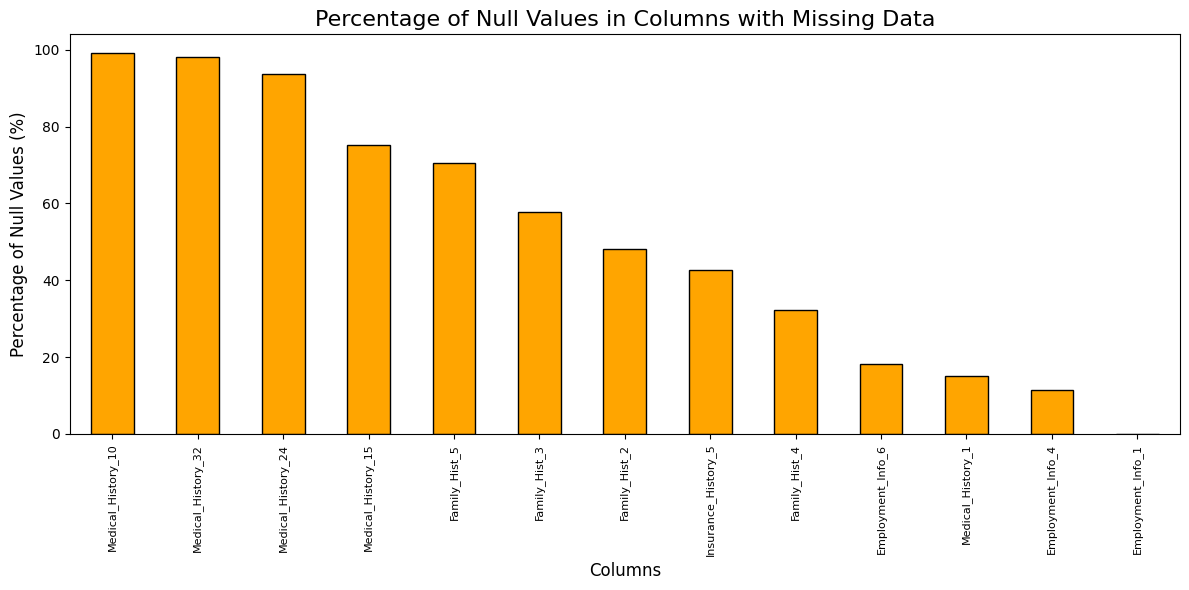

In [ ]:
null_percentage = df.isnull().mean() * 100

null_percentage_sorted = null_percentage.sort_values(ascending=False)
null_columns = null_percentage[null_percentage > 0]

# Lấy ra và sắp xếp các cột bị Null theo thứ tự giảm dần
null_columns_sorted = null_columns.sort_values(ascending=False)

# Vẽ biểu đồ tỉ lệ các cột bị Null
plt.figure(figsize=(12, 6))
null_columns_sorted.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Percentage of Null Values in Columns with Missing Data', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Percentage of Null Values (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Drop các cột bị missing value trên 60%
df.drop(['Medical_History_10','Medical_History_32','Medical_History_24','Medical_History_15','Family_Hist_5','Product_Info_2'],axis=1,inplace=True)

In [ ]:
# Drop các dòng với cột bị missing value dưới 5%
df.dropna(subset=['Employment_Info_1'],inplace=True)

In [ ]:
# Đếm số lượng Null trong các cột
features_with_nulls = {k:v for k, v in df.isnull().apply(sum).to_dict().items() if v > 0}
features_with_nulls

{'Employment_Info_4': 6775,
 'Employment_Info_6': 10848,
 'Insurance_History_5': 25383,
 'Family_Hist_2': 28641,
 'Family_Hist_3': 34233,
 'Family_Hist_4': 19170,
 'Medical_History_1': 8884}

In [ ]:
def loosen_limits(ax, which='x'):
    if which == 'x' or which == 'xy':
        x0, x1 = ax.get_xlim()
        xr = x1 - x0
        ax.set_xlim(x0 - 0.05 *xr, x1 + 0.05 * xr)
    elif  which == 'y' or which == 'xy':
        y0, y1 = ax.get_ylim()
        yr = y1 - y0
        ax.set_ylim(y0 - 0.05 *yr, y1 + 0.05 * yr)

def make_hist(df, cols, ylog=False):
    ysize = (len(cols) // 5 + 1) * 3.
    ax = df[cols].hist(figsize=(16,ysize), bins=50, sharex=False, layout=(-1,5))
    for axes in ax.flat:
        loosen_limits(axes)
        name = axes.get_title()
        if name == '':
            continue

        axes.set_title("{} [{:d}]".format(name, df[name].count()), fontsize=10)
        if ylog:
            axes.set_yscale('log')

def make_hexbin(df, col):
    ax = df.plot(kind='hexbin', x=col, y='Response', sharex=False, gridsize=25, norm=plt.colors.PowerNorm(1/2))
    ax.set_ylim(0., 9)
    loosen_limits(ax)
    ax.set_title(col, fontsize=10)
    return ax

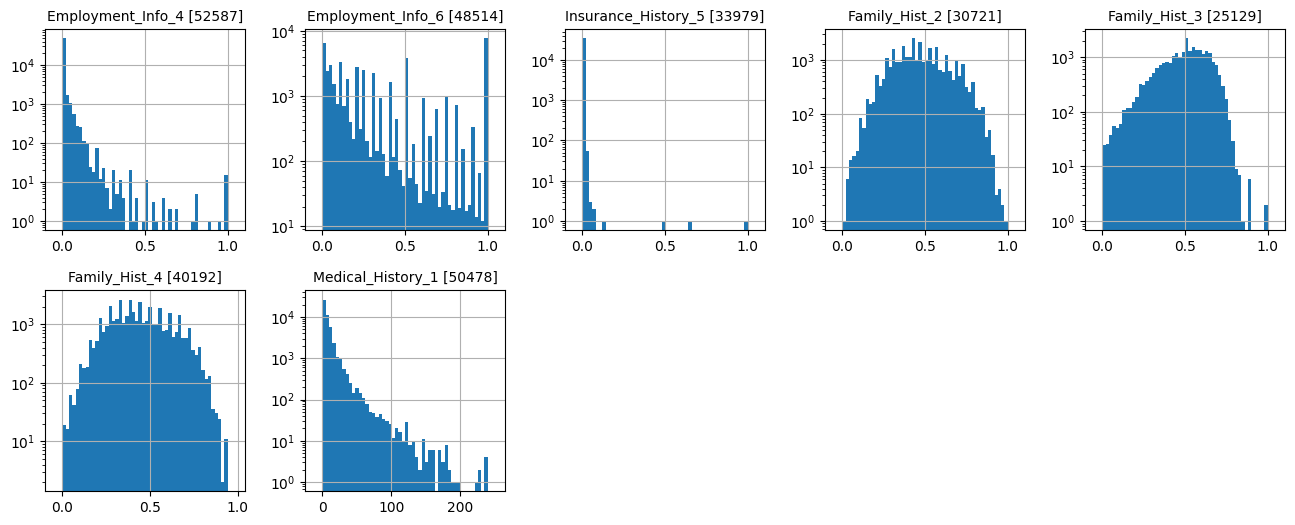

In [ ]:
na_cols = list(features_with_nulls.keys())
make_hist(df, na_cols, ylog=True)

Thay thế giá trị null bằng giá trị trung vị cho các cột Employment_Info_4, Employment_Info_6, Insurance_History_5, Medical_History_1:

In [ ]:
columns_median = df[['Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 'Medical_History_1']]
columns_mean = df[['Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4']]

# Thay thế giá trị null cho các cột phân phối không đều bằng median
for col in columns_median:
    df[col].fillna(df[col].median(), inplace=True)

# Thay thế giá trị null cho các cột phân phối chuẩn bằng mean
for col in columns_mean:
    df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
df.isnull().sum().sum()

0

## Feature Engineering

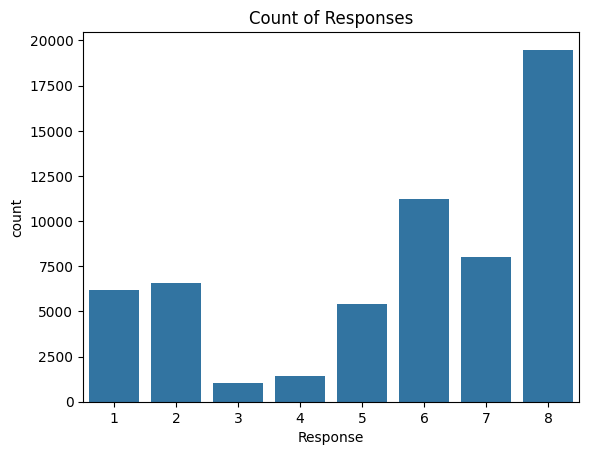

In [ ]:
sns.countplot(x=df['Response'])
plt.title('Count of Responses')
plt.show()

In [ ]:
df['Modified_Response']  = df['Response'].apply(lambda x : 0 if x<=5 and x>=0 else (1 if x <= 7 else 2))

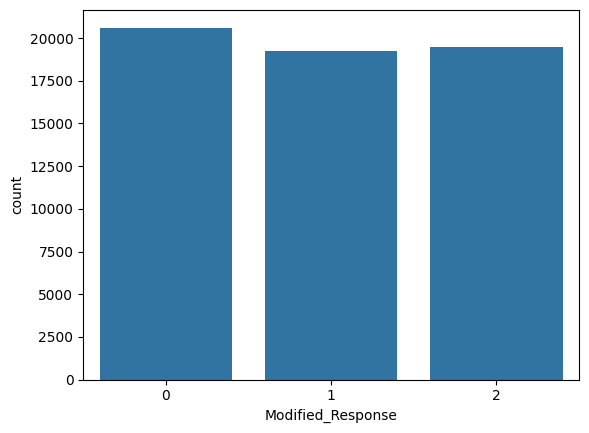

In [ ]:
sns.countplot(x=df['Modified_Response'])
plt.show()

In [ ]:
df.drop('Response',axis=1,inplace=True)

In [ ]:
df['BMI_Age'] = df['BMI'] * df['Ins_Age']

In [ ]:
df[['Id', 'BMI', 'Ins_Age', 'BMI_Age']].head(10)

,Id,BMI,Ins_Age,BMI_Age
0,2,0.323008,0.641791,0.207304
1,5,0.272288,0.059701,0.016256
2,6,0.428780,0.029851,0.012799
3,7,0.352438,0.164179,0.057863
4,8,0.424046,0.417910,0.177213
5,10,0.364887,0.507463,0.185166
6,11,0.376587,0.373134,0.140517
7,14,0.571612,0.611940,0.349792
8,15,0.362643,0.522388,0.189440
9,16,0.587796,0.552239,0.324604


In [ ]:
df['Med_keyword_count'] = df.filter(like='Medical_Keyword').sum(axis=1)

In [ ]:
df[['Id','Med_keyword_count']].sample(10)

,Id,Med_keyword_count
41021,54507,0
43572,57926,2
32837,43574,0
32202,42723,2
42495,56486,0
58011,77302,1
22548,30039,1
41904,55660,4
42156,56013,2
40150,53327,0


## Building ML Model

In [ ]:
features=['BMI', 'Wt', 'BMI_Age', 'Product_Info_4', 'Ins_Age', 'Employment_Info_1', 'Ht', 'Family_Hist_4', 'Medical_History_4',
          'Employment_Info_6', 'Medical_History_2', 'Medical_History_1', 'Family_Hist_2', 'Family_Hist_3', 'Insurance_History_5',
          'Medical_History_23', 'InsuredInfo_3', 'Med_keyword_count', 'Medical_Keyword_15', 'Employment_Info_2', 'InsuredInfo_6',
          'Medical_Keyword_3','Medical_History_4']

In [ ]:
df_filtered=df[features]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    df_filtered, y, test_size=0.3, random_state=42
)
# Áp dụng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Khởi tạo mô hình XGBoost
model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Định nghĩa các tham số cho GridSearch
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Sử dụng GridSearchCV để tìm tham số tối ưu
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Huấn luyện với GridSearch
grid_search.fit(X_train_scaled, y_train)

# In ra tham số tối ưu
print("Best parameters found: ", grid_search.best_params_)


# Dự đoán với mô hình tối ưu
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test_scaled), multi_class='ovr')

# In các chỉ số đánh giá
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.9}
Accuracy: 0.6612948509180752
Precision: 0.6649139682393562
Recall: 0.663229449345943
F1 Score: 0.6574883979999702
ROC AUC: 0.8381121967627682


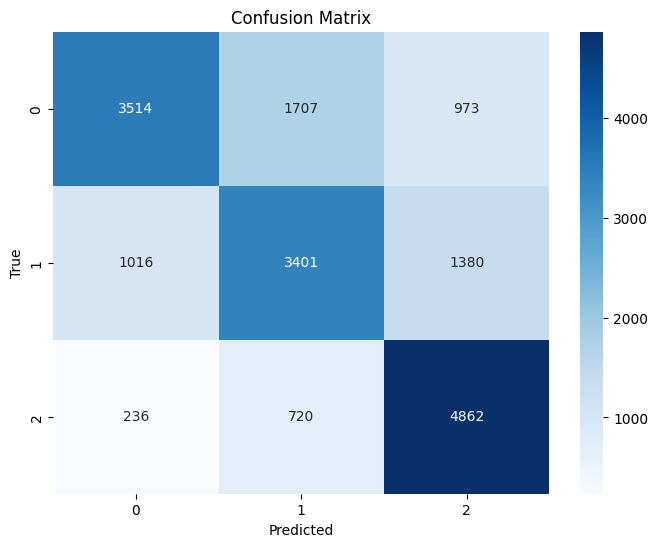

In [ ]:
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# In báo cáo chi tiết các lớp
report = classification_report(y_test, y_pred)
print("Đánh giá chi tiết các lớp:")
print(report)

Đánh giá chi tiết các lớp:
              precision    recall  f1-score   support

           0       0.74      0.57      0.64      6194
           1       0.58      0.59      0.59      5797
           2       0.67      0.84      0.75      5818

    accuracy                           0.66     17809
   macro avg       0.66      0.66      0.66     17809
weighted avg       0.67      0.66      0.66     17809

